In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import json

from sklearn.preprocessing import OneHotEncoder

In [2]:
data =pd.read_csv("Housing.csv")

'''converting yes or no to 1 and 0   '''

yes_no_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
data[yes_no_cols] = data[yes_no_cols].replace({"yes" : 1 , "no" : 0})

''' converting to One-hot encoding method for furnishing status 👇 '''

dummies = pd.get_dummies(data['furnishingstatus'], prefix='')
dummies = dummies.astype(int) #converting true/false to 1/0
data = pd.concat([data,dummies] , axis = 1)
data = data.drop("furnishingstatus" , axis = 1)

/tmp/ipython-input-76997899.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[yes_no_cols] = data[yes_no_cols].replace({"yes" : 1 , "no" : 0})


In [3]:
y = data["price"]
x = data.drop(columns=["price"])

# Convert to NumPy arrays and Split data BEFORE normalization
x_np = x.values
y_np = y.values.reshape(-1, 1) # Ensure y is a 2D array for consistent matrix operations

np.random.seed(1)
shuffling_index = np.random.permutation(len(x_np))
split_index = int(0.8 * len(shuffling_index))

x_train_raw = x_np[shuffling_index[:split_index]]
y_train_raw = y_np[shuffling_index[:split_index]]
x_test_raw = x_np[shuffling_index[split_index:]]
y_test_raw = y_np[shuffling_index[split_index:]]

In [4]:
''' Feature Scaling - Modified function to avoid data leakage '''

def z_score_normalization_split(x_train_raw, y_train_raw, x_test_raw, y_test_raw):
    # Calculate mean and std ONLY on the training data
    mean_x_train = np.mean(x_train_raw, axis=0)
    std_x_train = np.std(x_train_raw, axis=0)
    mean_y_train = np.mean(y_train_raw, axis=0)
    std_y_train = np.std(y_train_raw, axis=0)

    # Handle potential zero std (for constant features), prevent division by zero
    std_x_train[std_x_train == 0] = 1e-8
    std_y_train[std_y_train == 0] = 1e-8

    # Apply the training stats to both training and test sets
    x_train_norm = (x_train_raw - mean_x_train) / std_x_train
    y_train_norm = (y_train_raw - mean_y_train) / std_y_train

    x_test_norm = (x_test_raw - mean_x_train) / std_x_train
    y_test_norm = (y_test_raw - mean_y_train) / std_y_train

    return x_train_norm, y_train_norm, x_test_norm, y_test_norm

# Call the new normalization function
x_train, y_train, x_test, y_test = z_score_normalization_split(x_train_raw, y_train_raw, x_test_raw, y_test_raw)

In [5]:
def number_of_layers(x_train , y_train):
  input_layer_size = x_train.shape[1]
  hidden_layer_size = [32,16,8]
  output_layer_size = 1

  return input_layer_size ,hidden_layer_size ,output_layer_size

input_layer , hidden , output = number_of_layers(x_train , y_train)

print(input_layer)
print(hidden)
print(output)

14
[32, 16, 8]
1


In [6]:
# def initilizing_weights(input_layer, hidden, output):
#     w1 = np.random.randn(input_layer, hidden[0]) * 0.01 #it gives ( i want some random numbers who's spae is in (input_layer, hidden[0]) this  )
#     b1 = np.zeros((1, hidden[0]))  # (1, 32)
#     w2 = np.random.randn(hidden[0], hidden[1]) * 0.01
#     b2 = np.zeros((1, hidden[1]))  # (1, 16)
#     w3 = np.random.randn(hidden[1], hidden[2]) * 0.01
#     b3 = np.zeros((1, hidden[2]))  # (1, 8)
#     w4 = np.random.randn(hidden[2], output) * 0.01
#     b4 = np.zeros((1, output))     # (1, 1)

#     parameters = {
#         "w1": w1, "w2": w2, "w3": w3, "w4": w4,
#         "b1": b1, "b2": b2, "b3": b3, "b4": b4
#     }
#     return parameters

In [7]:
def initilizing_weights(input_layer, hidden, output):
    # Apply He-like initialization for Leaky ReLU layers (sqrt(2 / n_in))
    w1 = np.random.randn(input_layer, hidden[0]) * np.sqrt(2 / input_layer)
    b1 = np.zeros((1, hidden[0]))
    w2 = np.random.randn(hidden[0], hidden[1]) * np.sqrt(2 / hidden[0])
    b2 = np.zeros((1, hidden[1]))
    w3 = np.random.randn(hidden[1], hidden[2]) * np.sqrt(2 / hidden[1])
    b3 = np.zeros((1, hidden[2]))
    # For the linear output layer, a smaller scale like 0.01 is often appropriate.
    w4 = np.random.randn(hidden[2], output) * 0.01 # Keep this as 0.01
    b4 = np.zeros((1, output))

    parameters = {
        "w1": w1, "w2": w2, "w3": w3, "w4": w4,
        "b1": b1, "b2": b2, "b3": b3, "b4": b4
    }
    return parameters

In [8]:
parameters = initilizing_weights(input_layer, hidden, output)

print(parameters["w1"].shape)
print(parameters["w2"].shape)
print(parameters["w3"].shape)
print(parameters["w4"].shape)
print(parameters["b1"].shape)
print(parameters["b2"].shape)
print(parameters["b3"].shape)
print(parameters["b4"].shape)


(14, 32)
(32, 16)
(16, 8)
(8, 1)
(1, 32)
(1, 16)
(1, 8)
(1, 1)


In [9]:
def leaky_relu(z, alpha=0.01):
    relu = np.where(z > 0, z, alpha * z)
    return relu


In [10]:
def forward_propagation(X , parameters):


  w1 = parameters["w1"]
  w2 = parameters["w2"]
  w3 = parameters["w3"]
  w4 = parameters["w4"]

  b1 = parameters["b1"]
  b2 = parameters["b2"]
  b3 = parameters["b3"]
  b4 = parameters["b4"]

  z1 = np.dot(X ,w1 ) + b1
  A1 = leaky_relu(z1)

  z2 = np.dot(A1,w2) + b2
  A2 = leaky_relu(z2)

  z3 = np.dot(A2 ,w3 ) + b3
  A3 = leaky_relu(z3)

  z4 = np.dot(A3,w4) + b4
  A4 = z4

  chache = {"z1" : z1,
            "z2" : z2,
            "z3" : z3,
            "z4" : z4,
            "A1" : A1,
            "A2" : A2,
            "A3" : A3,
            "A4" : A4}


  return A4,chache

In [11]:
# Make predictions on training data
predictions, cache = forward_propagation(x_train, parameters)

print("Predictions shape:", predictions.shape)
print("First 5 predictions:\n", predictions[:5])
print("\nCache contains:", list(cache.keys()))
print(cache["A3"].shape)


Predictions shape: (436, 1)
First 5 predictions:
 [[ 0.01584903]
 [ 0.00547038]
 [-0.0249472 ]
 [-0.00158482]
 [-0.00184023]]

Cache contains: ['z1', 'z2', 'z3', 'z4', 'A1', 'A2', 'A3', 'A4']
(436, 8)


In [12]:
def loss_function(predictions,y_train):
  m = len(y_train)

  cost = (1 / (2 * m)) * np.sum((predictions - y_train) ** 2)
  return cost
cost_value  = loss_function(predictions,y_train)
print(f"The cost value is : {cost_value}")

The cost value is : 0.498476074863729


In [13]:
def leaky_relu_derivative(z, alpha=0.01):
    """
    Derivative of Leaky ReLU activation
    Returns 1 if z > 0, else alpha
    """
    return np.where(z > 0, 1, alpha)

In [14]:
print("w")
print(parameters["w1"].shape)
print(parameters["w2"].shape)
print(parameters["w3"].shape)
print(parameters["w4"].shape)
print("A")
print(cache["A1"].shape)
print(cache["A2"].shape)
print(cache["A3"].shape)
print(cache["A4"].shape)
print(f"y_train shape : {y_train.shape}")
print("z")
print(cache["z1"].shape)
print(cache["z2"].shape)
print(cache["z3"].shape)
print(cache["z4"].shape)
z3 = leaky_relu_derivative(cache["z3"] , alpha=0.01)
print(z3.shape)

w
(14, 32)
(32, 16)
(16, 8)
(8, 1)
A
(436, 32)
(436, 16)
(436, 8)
(436, 1)
y_train shape : (436, 1)
z
(436, 32)
(436, 16)
(436, 8)
(436, 1)
(436, 8)


In [15]:
def backward_propagation(x_train,y_train,parameters,cache):

  m = len(y_train)

  w1 = parameters["w1"]
  w2 = parameters["w2"]
  w3 = parameters["w3"]
  w4 = parameters["w4"]


  z1 = cache["z1"]
  z2 = cache["z2"]
  z3 = cache["z3"]
  z4 = cache["z4"]

  A1 = cache["A1"]
  A2 = cache["A2"]
  A3 = cache["A3"]
  A4 = cache["A4"]

  if y_train.ndim == 1:
        y_train = y_train.reshape(-1, 1)

  dz4 = A4 - y_train #shape(m,1)

  dw4 = (1/m) * np.dot(A3.T,dz4) #shape(8,1)
  db4 = (1/m) * np.sum(dz4,axis = 0 ,keepdims = True)

  dA3 = np.dot(dz4,w4.T)

  dz3 = dA3 * leaky_relu_derivative(z3)

  dw3 = (1/m) * np.dot(A2.T,dz3)
  db3 = (1/m) * np.sum(dz3, axis = 0, keepdims = True)

  dA2 = np.dot(dz3,w3.T)

  dz2 = dA2 * leaky_relu_derivative(z2)

  dw2 = (1/m) * np.dot(A1.T, dz2)
  db2 = (1/m) * np.sum(dz2, axis = 0, keepdims = True)

  dA1 = np.dot(dz2,w2.T)

  dz1 = dA1 * leaky_relu_derivative(z1)

  dw1 = (1/m) * np.dot(x_train.T,dz1)
  db1 = (1/m) * np.sum(dz1, axis = 0 ,keepdims = True)

  gradient = {
              "dw1" : dw1,
              "dw2" : dw2,
              "dw3" : dw3,
              "dw4" : dw4,

              "db1" : db1,
              "db2" : db2,
              "db3" : db3,
              "db4" : db4,
              }
  return gradient



In [16]:
gradients = backward_propagation(x_train, y_train, parameters, cache)

print("Gradient shapes:")
print("dw1:", gradients["dw1"].shape)
print("dw2:", gradients["dw2"].shape)
print("dw3:", gradients["dw3"].shape)
print("dw4:", gradients["dw4"].shape)
print("\nBias gradients:")
print("db1:", gradients["db1"].shape)
print("db2:", gradients["db2"].shape)
print("db3:", gradients["db3"].shape)
print("db4:", gradients["db4"].shape)

Gradient shapes:
dw1: (14, 32)
dw2: (32, 16)
dw3: (16, 8)
dw4: (8, 1)

Bias gradients:
db1: (1, 32)
db2: (1, 16)
db3: (1, 8)
db4: (1, 1)


In [17]:
def update_parameters(parameters, gradients, learning_rate):

  parameters["w1"] = parameters["w1"] - learning_rate * gradients["dw1"]
  parameters["w2"] = parameters["w2"] - learning_rate * gradients["dw2"]
  parameters["w3"] = parameters["w3"] - learning_rate * gradients["dw3"]
  parameters["w4"] = parameters["w4"] - learning_rate * gradients["dw4"]


  parameters["b1"] =  parameters["b1"] - learning_rate * gradients["db1"]
  parameters["b2"] =  parameters["b2"] - learning_rate * gradients["db2"]
  parameters["b3"] =  parameters["b3"] - learning_rate * gradients["db3"]
  parameters["b4"] =  parameters["b4"] - learning_rate * gradients["db4"]


  return parameters

In [18]:
def train_model(x_train,y_train,parameters,learning_rate , num_iters,print_cost):
  m = len(y_train)

  cost = []

  for i in range(num_iters):

    predictions, cache = forward_propagation(x_train, parameters)

    gradients = backward_propagation(x_train, y_train, parameters, cache)

    parameters = update_parameters(parameters, gradients, learning_rate)

    cost_value  = loss_function(predictions,y_train)
    cost.append(cost_value)


    if print_cost and i%10000 == 0: # Print cost every 100 iterations
      print(f"No.of iteration {i:4d} cost is {cost_value:0.4f}")

  return cost , parameters
cost_history , updated_parameters = train_model(x_train,y_train,parameters,learning_rate = 0.01 , num_iters = 500000,print_cost = True)

No.of iteration    0 cost is 0.4985
No.of iteration 10000 cost is 0.0444
No.of iteration 20000 cost is 0.0229
No.of iteration 30000 cost is 0.0167
No.of iteration 40000 cost is 0.0140
No.of iteration 50000 cost is 0.0125
No.of iteration 60000 cost is 0.0111
No.of iteration 70000 cost is 0.0098
No.of iteration 80000 cost is 0.0086
No.of iteration 90000 cost is 0.0074
No.of iteration 100000 cost is 0.0062
No.of iteration 110000 cost is 0.0052
No.of iteration 120000 cost is 0.0046
No.of iteration 130000 cost is 0.0041
No.of iteration 140000 cost is 0.0039
No.of iteration 150000 cost is 0.0038
No.of iteration 160000 cost is 0.0036
No.of iteration 170000 cost is 0.0036
No.of iteration 180000 cost is 0.0035
No.of iteration 190000 cost is 0.0034
No.of iteration 200000 cost is 0.0033
No.of iteration 210000 cost is 0.0033
No.of iteration 220000 cost is 0.0032
No.of iteration 230000 cost is 0.0032
No.of iteration 240000 cost is 0.0032
No.of iteration 250000 cost is 0.0031
No.of iteration 260000 

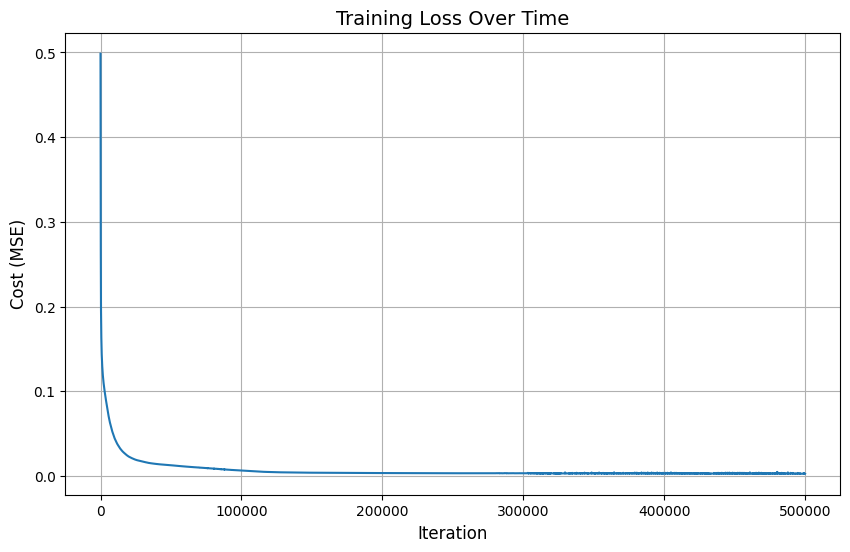

Initial cost: 0.4985
Final cost: 0.0026
Cost reduction: 0.4959
Reduction %: 99.48%


In [19]:

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(cost_history)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cost (MSE)', fontsize=12)
plt.title('Training Loss Over Time', fontsize=14)
plt.grid(True)
plt.show()

# Print summary
print(f"Initial cost: {cost_history[0]:.4f}")
print(f"Final cost: {cost_history[-1]:.4f}")
print(f"Cost reduction: {cost_history[0] - cost_history[-1]:.4f}")
print(f"Reduction %: {((cost_history[0] - cost_history[-1]) / cost_history[0] * 100):.2f}%")

In [20]:
train_prediction, _ = forward_propagation(x_train , updated_parameters)
train_cost = loss_function(train_prediction , y_train)

test_prediction, _ = forward_propagation(x_test , updated_parameters)
test_cost = loss_function(test_prediction , y_test )

print(train_cost)
print(test_cost)



if test_cost / train_cost < 1.3:
    print("✅ Good generalization!")
else:
    print("⚠️ Possible overfitting")



0.002602212714490549
1.8484898705900803
⚠️ Possible overfitting


In [21]:
#Saving the updated parameters to json file
def save_model_to_json(parameters, filename = "model_parameters.json"):
  serializable_params = {}
  for key , value in parameters.items():
    serializable_params[key] = value.tolist()

  with open(filename , "w") as json_file:
    json.dump(serializable_params, json_file)

  print("The file saved sucessfully")

save_model_to_json(updated_parameters)

The file saved sucessfully


In [22]:
#Loading the updated parameters form json file when ever needed
def load_model_from_json(filename="model_parameters.json"):
    with open(filename, "r") as json_file:
        loaded_params = json.load(json_file)


    for key, value in loaded_params.items():
        loaded_params[key] = np.array(value)

    print(f"✅ Model loaded successfully from {filename}")
    return loaded_params


loaded_parameters = load_model_from_json()

✅ Model loaded successfully from model_parameters.json


In [23]:
# Reversing the normalised data to get actual predictin

mean_x_train = np.mean(x_train_raw, axis=0)
std_x_train = np.std(x_train_raw, axis=0)
mean_y_train = np.mean(y_train_raw, axis=0)
std_y_train = np.std(y_train_raw, axis=0)

norm_stats = {
    "mean_x": mean_x_train.tolist(),
    "std_x": std_x_train.tolist(),
    "mean_y": mean_y_train.tolist(),
    "std_y": std_y_train.tolist()
}

with open("normalization.json", "w") as f:
    json.dump(norm_stats, f)


✅ Model Evaluation Metrics
Training MSE: 0.0052
Test MSE: 3.6970
Training RMSE: 0.0721
Test RMSE: 1.9228
Training R²: 0.9948
Test R²: -2.5440


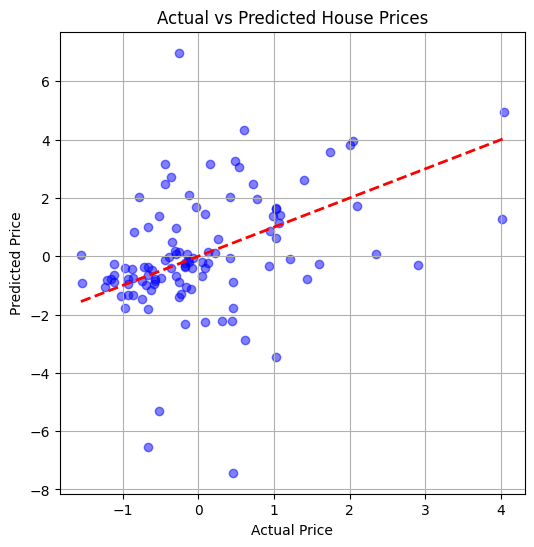

In [24]:
# --- All-in-one Model Evaluation Code ---

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# --- Forward propagation function ---
def leaky_relu(z, alpha=0.01):
    return np.where(z > 0, z, alpha*z)

def forward_propagation(X, parameters):
    w1, w2, w3, w4 = parameters["w1"], parameters["w2"], parameters["w3"], parameters["w4"]
    b1, b2, b3, b4 = parameters["b1"], parameters["b2"], parameters["b3"], parameters["b4"]

    z1 = np.dot(X, w1) + b1
    A1 = leaky_relu(z1)
    z2 = np.dot(A1, w2) + b2
    A2 = leaky_relu(z2)
    z3 = np.dot(A2, w3) + b3
    A3 = leaky_relu(z3)
    z4 = np.dot(A3, w4) + b4
    A4 = z4
    return A4

# --- Metrics functions ---
def mse(y_true, y_pred):
    m = len(y_true)
    return np.sum((y_true - y_pred)**2) / m

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

# --- Predictions ---
train_pred = forward_propagation(x_train, updated_parameters)
test_pred = forward_propagation(x_test, updated_parameters)

# --- Compute metrics ---
train_mse = mse(y_train, train_pred)
test_mse = mse(y_test, test_pred)

train_rmse = rmse(y_train, train_pred)
test_rmse = rmse(y_test, test_pred)

train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

print("✅ Model Evaluation Metrics")
print(f"Training MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

# --- Plot Actual vs Predicted ---
plt.figure(figsize=(6,6))
plt.scatter(y_test, test_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted House Prices")
plt.grid(True)
plt.show()
